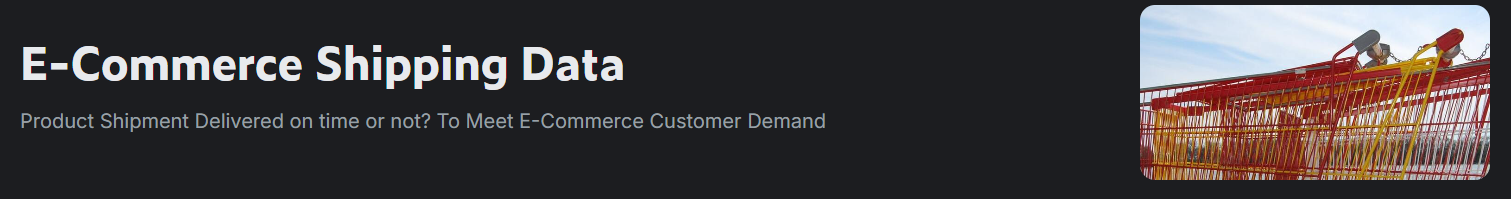

[https://www.kaggle.com/datasets/prachi13/customer-analytics/data]

# E-Commerce Shipping Data: 배송 지연 예측 및 분석

**프로젝트 개요:**
본 프로젝트는 전자상거래 배송 데이터를 분석하여 **제품의 배송 지연 여부(Reached.on.Time_Y.N)**를 예측하는 머신러닝 모델을 구축합니다. 
단순한 예측을 넘어, EDA를 통해 지연의 핵심 원인을 파악하고 파생변수를 생성하여 모델 성능을 최적화하는 과정을 담고 있습니다.

## 목차
1. [데이터셋 소개](#0-데이터셋-소개)
2. [라이브러리 임포트 & 데이터 로딩](#1-라이브러리-임포트)
3. [탐색적 데이터 분석 (EDA)](#시각화)
4. [전처리](#4-전처리)
5. [특성 공학](#5-특성-공학)
6. [모델링](#6-모델링)
7. [하이퍼파라미터 튜닝](#7-하이퍼파라미터-튜닝)
8. [모델 평가](#8-모델-평가)

## 1. 데이터셋 소개 <a id='0-데이터셋-소개'></a>

**데이터 명세 (Data Dictionary)**
총 10,999개의 데이터와 12개의 컬럼으로 구성되어 있습니다.

| 구분 | 컬럼명 | 설명 | 데이터 타입 | 비고 |
|:---:|:---|:---|:---:|:---|
| **Target** | `Reached.on.Time_Y.N` | 배송 지연 여부 (1: 정시 도착, 0: 지연) | int64 | **Target Variable** |
| **Index** | `ID` | 고유 식별자 | int64 | 분석 시 제거 예정 |
| **Categorical** | `Warehouse_block` | 창고 구역 (A, B, C, D, F) | object | |
| | `Mode_of_Shipment` | 배송 수단 (Ship, Flight, Road) | object | |
| | `Product_importance` | 제품 중요도 (low, medium, high) | object | |
| | `Gender` | 고객 성별 (F, M) | object | |
| **Numerical** | `Customer_care_calls` | 고객센터 전화 횟수 | int64 | |
| | `Customer_rating` | 고객 만족도 (1~5) | int64 | |
| | `Cost_of_the_Product` | 제품 가격 | int64 | |
| | `Prior_purchases` | 이전 구매 횟수 | int64 | |
| | `Discount_offered` | 제공된 할인율 | int64 | **핵심 변수** |
| | `Weight_in_gms` | 제품 무게 (g) | int64 | **핵심 변수** |

## 2. 라이브러리 임포트 & 데이터 로딩 <a id='1-라이브러리-임포트'></a>

분석과 모델링에 필요한 핵심 라이브러리를 로드하고, OS 경로 호환성을 고려하여 데이터를 불러옵니다.

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 운영체제별 한글 폰트 설정
system_name = platform.system()
if system_name == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif system_name == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Linux': # Colab 등 (나눔폰트 설치 필요할 수 있음)
    plt.rc('font', family='NanumBarunGothic')

# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 1. 현재 작업 경로(Current Working Directory) 가져오기
HOME = os.getcwd()

# 2. 경로 결합 (OS에 상관없이 안전하게 경로 생성)
# 구조: [현재폴더] / data / Train.csv
dataPath = os.path.join(HOME, 'data', 'Train.csv')

# 3. 데이터 읽기
try:
    train_df = pd.read_csv(dataPath)
    print(f"▶ 데이터 로드 성공: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Error: 아직 폴더 구조가 안 맞아요! 위 1~3단계를 다시 확인해주세요.")

NameError: name 'platform' is not defined

In [5]:
# 데이터 기본 정보 확인
print("\n▶ 데이터 정보 (Info):")
train_df.info()

print("\n▶ 결측치 확인:")
print(train_df.isnull().sum())


▶ 데이터 정보 (Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB

▶ 결측치 확인:
ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
C

## 3. 탐색적 데이터 분석 (EDA) <a id='2-탐색적-데이터-분석'></a>

데이터의 품질을 점검하고 기초 통계량을 확인하여 전처리 방향성을 설정합니다.
- **결측치(Missing Values)** 확인
- **중복값(Duplicates)** 확인
- **기초 통계량(Statistics)** 분석

In [6]:
# 1. 데이터 요약 정보
print(f"{'='*20} [Data Info] {'='*20}")
df.info()

# 2. 결측치 및 중복값 확인
print(f"\n{'='*20} [Quality Check] {'='*20}")
null_cnt = df.isnull().sum().sum()
dup_cnt = df.duplicated().sum()
print(f"▶ 총 결측치 수 : {null_cnt}개")
print(f"▶ 중복 데이터 수: {dup_cnt}개")

# 3. 기초 통계량 확인
print(f"\n{'='*20} [Statistics] {'='*20}")
display(df.describe().T)

==================== [Data Info] ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB

==================== [Quality Check] ====================
▶ 총 결측치 수 : 0개
▶ 중복 데이터 수: 0개

===========

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


C:\Users\User\AppData\Local\Temp\ipykernel_26376\1625770550.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x='Is_Clearance', y=target, ax=axes[1, 1], palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_26376\1625770550.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['일반(<=10)', '행사(>10)'])
c:\Users\User\miniconda3\envs\DS\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\miniconda3\envs\DS\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

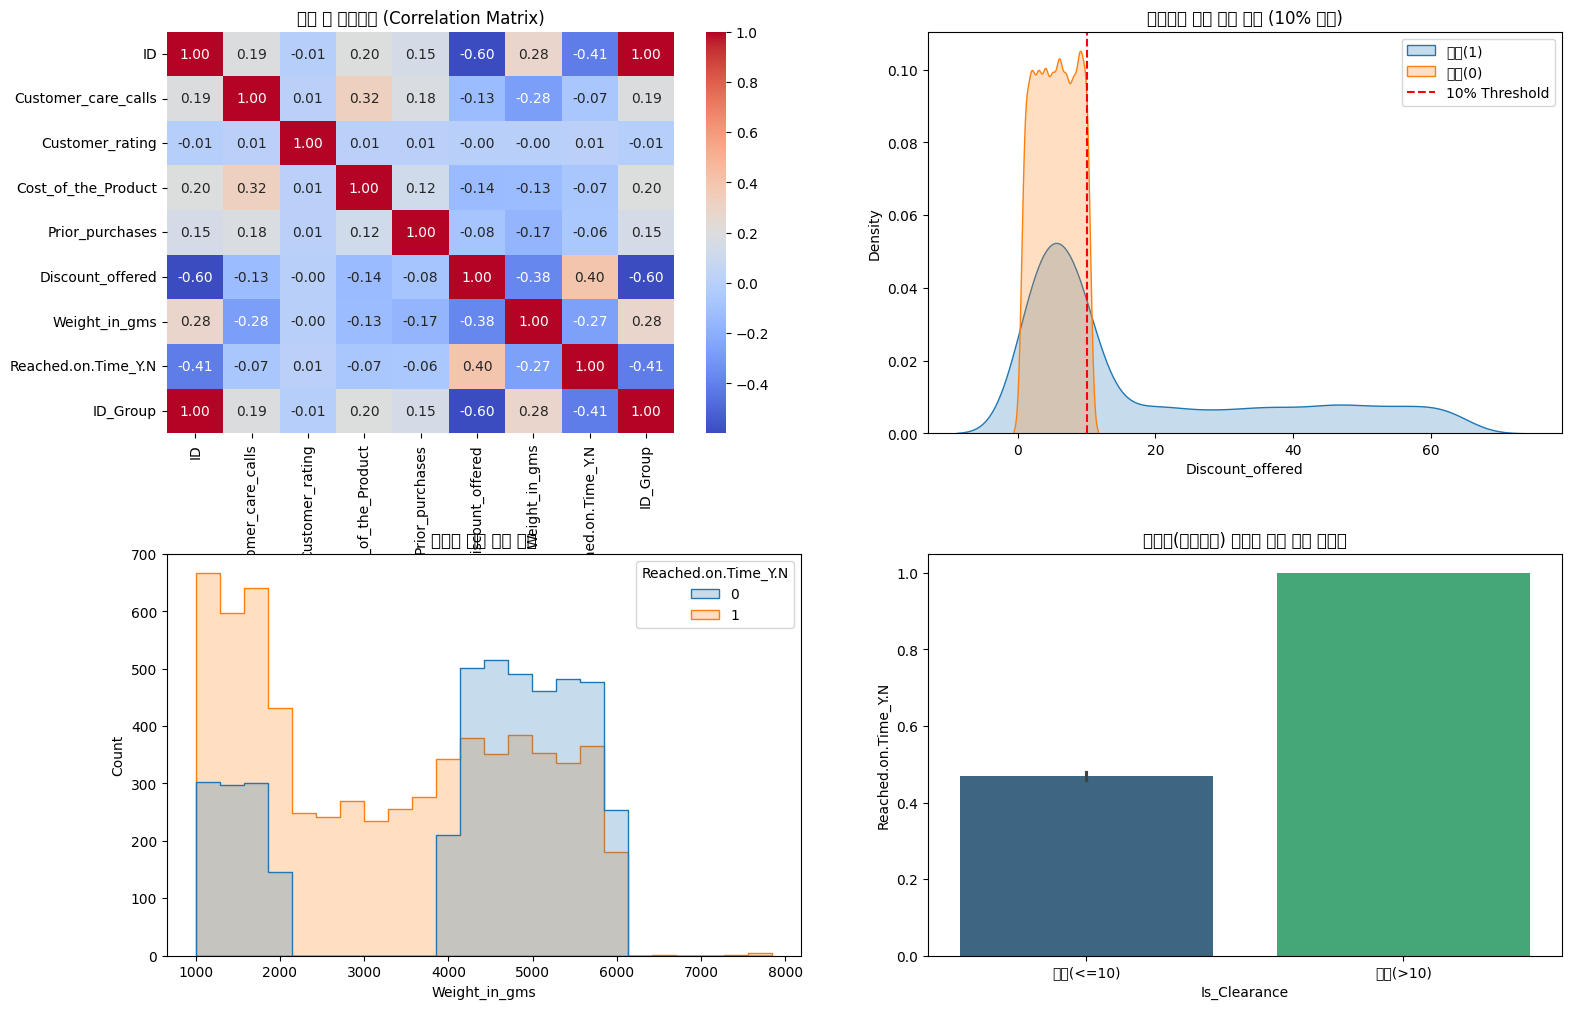

In [12]:
# 1. 타겟 변수 정의 
target = 'Reached.on.Time_Y.N'

# 2. 시각화 시작
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.3)

# [그래프 1] 상관관계 히트맵
# 수치형 변수만 골라서 상관관계 계산
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('변수 간 상관관계 (Correlation Matrix)')

# [그래프 2] 할인율(Discount) 가설 검증
sns.kdeplot(data=df[df[target]==1], x='Discount_offered', fill=True, label='정시(1)', ax=axes[0, 1])
sns.kdeplot(data=df[df[target]==0], x='Discount_offered', fill=True, label='지연(0)', ax=axes[0, 1])
axes[0, 1].axvline(10, color='red', linestyle='--', label='10% Threshold')
axes[0, 1].set_title('할인율에 따른 지연 분포 (10% 기준)')
axes[0, 1].legend()

# [그래프 3] 무게(Weight) 구간별 분포
sns.histplot(data=df, x='Weight_in_gms', hue=target, element="step", ax=axes[1, 0])
axes[1, 0].set_title('무게별 배송 지연 분포')

# [그래프 4] 재고 떨이(Clearance) 가설 증명
# 임시 변수 생성 (시각화용)
temp_df = df.copy()
temp_df['Is_Clearance'] = temp_df['Discount_offered'] > 10
sns.barplot(data=temp_df, x='Is_Clearance', y=target, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('고할인(재고떨이) 여부에 따른 정시 도착률')
axes[1, 1].set_xticklabels(['일반(<=10)', '행사(>10)'])

plt.show()

# 📦 무게(Weight)와 배송 지연의 관계 분석

## 1. 분석 배경
물류 시스템에서 **물품의 무게**는 운송 수단(항공, 선박, 트럭) 결정과 처리 속도에 직접적인 영향을 미치는 물리적 요인입니다. "무거울수록 처리가 늦어져 배송이 지연될 것이다"라는 일반적인 상식이 이 데이터셋에서도 통용되는지, 아니면 특정 무게 구간에서만 지연이 발생하는지 확인이 필요합니다.

## 2. 시각화 목표
* **분포 비교**: 정시 도착한 물품과 지연된 물품의 무게 분포가 다른가?
* **구간별 패턴**: 특정 무게(예: 4000g 이상)에서 지연 확률이 급격히 변하는가?
* **인사이트 도출**: 무게 변수를 모델의 주요 피처로 사용할 때, 어떤 구간 정보를 강조해야 하는가?

C:\Users\User\AppData\Local\Temp\ipykernel_26376\2311377115.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=weight_col, ax=axes[0], palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_26376\2311377115.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['On Time (0)', 'Delayed (1)'])
C:\Users\User\AppData\Local\Temp\ipykernel_26376\2311377115.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weight_delay_prob = df.groupby('Weight_Bin')[target_col].mean()


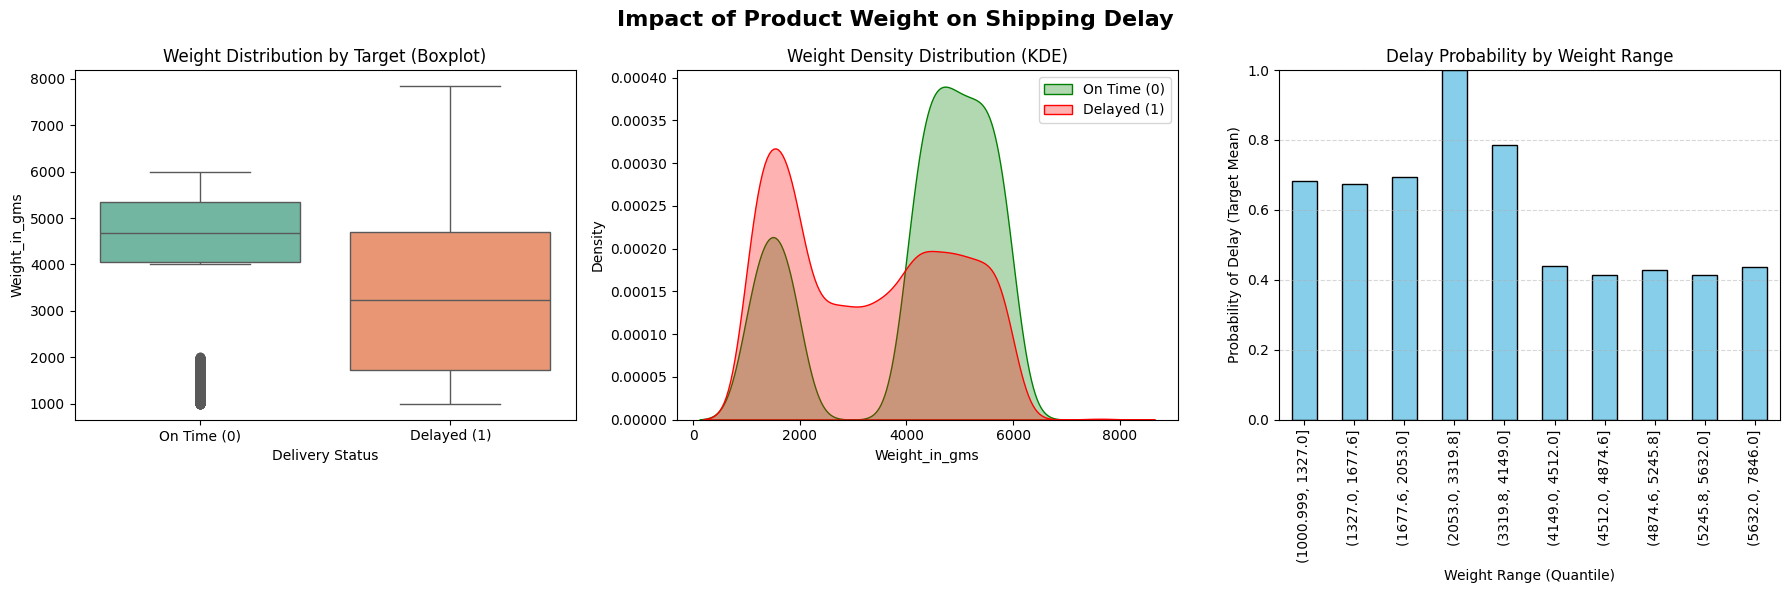

▶ [구간별 분석] 무게 구간별 정시 도착 vs 지연 비율


C:\Users\User\AppData\Local\Temp\ipykernel_26376\2311377115.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('Weight_Bin')[target_col].value_counts(normalize=True).unstack().style.format("{:.1%}").background_gradient(cmap='Reds'))


Reached.on.Time_Y.N,0,1
Weight_Bin,,
"(1000.999, 1327.0]",31.8%,68.2%
"(1327.0, 1677.6]",32.7%,67.3%
"(1677.6, 2053.0]",30.5%,69.5%
"(2053.0, 3319.8]",0.0%,100.0%
"(3319.8, 4149.0]",21.5%,78.5%
"(4149.0, 4512.0]",56.2%,43.8%
"(4512.0, 4874.6]",58.6%,41.4%
"(4874.6, 5245.8]",57.3%,42.7%
"(5245.8, 5632.0]",58.5%,41.5%


In [9]:
# -----------------------------------------------------------
# [시각화] 무게(Weight_in_gms)와 타겟(Reached.on.Time_Y.N) 관계 분석
# -----------------------------------------------------------

# 컬럼명 정의 (편의상 변수로 지정)
weight_col = 'Weight_in_gms'
target_col = 'Reached.on.Time_Y.N'

# 1. 캔버스 설정 (3개의 그래프를 한번에 그리기)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Impact of Product Weight on Shipping Delay', fontsize=16, fontweight='bold')

# [그래프 1] Boxplot: 타겟별 무게 분포 요약
# 중앙값과 사분위수를 통해 두 그룹(정시/지연)의 무게 차이를 직관적으로 비교
sns.boxplot(data=df, x=target_col, y=weight_col, ax=axes[0], palette='Set2')
axes[0].set_title('Weight Distribution by Target (Boxplot)', fontsize=12)
axes[0].set_xticklabels(['On Time (0)', 'Delayed (1)'])
axes[0].set_xlabel('Delivery Status')

# [그래프 2] KDE Plot: 무게 밀도 함수 비교 (겹침 확인)
# 두 그룹의 분포가 얼마나 겹치는지, 특정 무게에 몰려있는지 확인
sns.kdeplot(data=df[df[target_col]==0], x=weight_col, fill=True, label='On Time (0)', ax=axes[1], color='green', alpha=0.3)
sns.kdeplot(data=df[df[target_col]==1], x=weight_col, fill=True, label='Delayed (1)', ax=axes[1], color='red', alpha=0.3)
axes[1].set_title('Weight Density Distribution (KDE)', fontsize=12)
axes[1].legend()

# [그래프 3] Barplot: 무게 구간별 지연 발생률 (Trend)
# 무게를 10등급으로 나누어, 각 구간에서 '지연(1)'이 발생한 비율을 봅니다.
# 1에 가까울수록 해당 무게 구간은 배송이 지연될 확률이 높다는 뜻입니다.
df['Weight_Bin'] = pd.qcut(df[weight_col], q=10) # 무게를 10등분
weight_delay_prob = df.groupby('Weight_Bin')[target_col].mean()

weight_delay_prob.plot(kind='bar', ax=axes[2], color='skyblue', edgecolor='black')
axes[2].set_title('Delay Probability by Weight Range', fontsize=12)
axes[2].set_ylabel('Probability of Delay (Target Mean)')
axes[2].set_xlabel('Weight Range (Quantile)')
axes[2].set_ylim(0, 1) # 확률은 0~1 사이
axes[2].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.88) # 제목 공간 확보
plt.show()

# -----------------------------------------------------------
# [추가 분석] 특정 구간(예: 가벼운 물건 vs 무거운 물건) 수치 확인
# -----------------------------------------------------------
print("▶ [구간별 분석] 무게 구간별 정시 도착 vs 지연 비율")
# 보기 좋게 데이터프레임으로 출력
display(df.groupby('Weight_Bin')[target_col].value_counts(normalize=True).unstack().style.format("{:.1%}").background_gradient(cmap='Reds'))

## 3. 결과 해석 가이드

### 📉 그래프 1: Boxplot
* **박스 높이 차이**: 만약 `Delayed(1)` 박스가 `On Time(0)`보다 현저히 위나 아래에 있다면, 무게가 지연에 결정적인 역할을 한다는 뜻입니다.
* **해석**: 예를 들어, 지연된 물품들의 박스가 위쪽에 있다면 **"무거운 물건일수록 지연된다"**는 가설이 성립합니다.

### 📈 그래프 2: KDE Plot (밀도)
* **봉우리(Peak) 위치**: 
    * **초록색(0)**과 **빨간색(1)**의 봉우리가 서로 다른 무게 구간에 위치한다면, 무게는 예측 모델에서 매우 중요한 변수(Feature)입니다.
    * 만약 두 그래프가 거의 완벽하게 겹친다면, 무게는 배송 지연과 큰 상관이 없는 것입니다.
* **특이점**: 그래프가 쌍봉(봉우리가 2개) 형태라면, 물품이 **"가벼운 그룹"**과 **"무거운 그룹"**으로 명확히 나뉘는 특성이 있음을 의미합니다.

### 📊 그래프 3: Barplot (구간별 확률)
* **막대 높이의 변화**: 왼쪽(가벼움)에서 오른쪽(무거움)으로 갈수록 막대가 높아진다면 **양의 상관관계**(무거울수록 지연됨)입니다.
* **반전 구간**: 특정 무게 구간(예: 2000g~4000g)에서만 막대가 솟거나 꺼진다면, 그 구간에 특별한 배송 이슈(예: 특정 창고 처리)가 있음을 암시합니다.

# 📊 ID 변수 심층 분석: 할인율 관계 및 Data Leakage 검증

## 1. 분석 배경
일반적으로 **ID(식별자)**는 데이터베이스의 단순 순번(Index)으로, 예측 모델링에서 아무런 정보가 없어야 정상입니다. 하지만 데이터 수집 과정에서 특정 규칙(예: 타겟 변수 기준으로 정렬 후 ID 부여)이 개입되었다면, ID는 **가장 강력한 예측 변수**가 되어버리는 **Data Leakage(데이터 누수)** 문제를 일으킬 수 있습니다.

## 2. 검증 목표
본 분석에서는 다음 두 가지 가설을 시각화와 모델링을 통해 검증합니다.

1.  **ID와 할인율(Discount)의 관계**: 
    * ID 순서에 따라 할인율이 급격하게 변하는 구간이 있는가? (정책 변화 감지)
2.  **ID와 타겟(정시 도착 여부)의 관계 (Data Leakage)**:
    * ID가 타겟 값(0 또는 1)에 따라 정렬되어 있는가?
    * **검증 방법**: 오직 `ID` 변수 하나만으로 타겟을 예측했을 때 성능(AUC)이 비정상적으로 높다면 Leakage로 간주합니다.

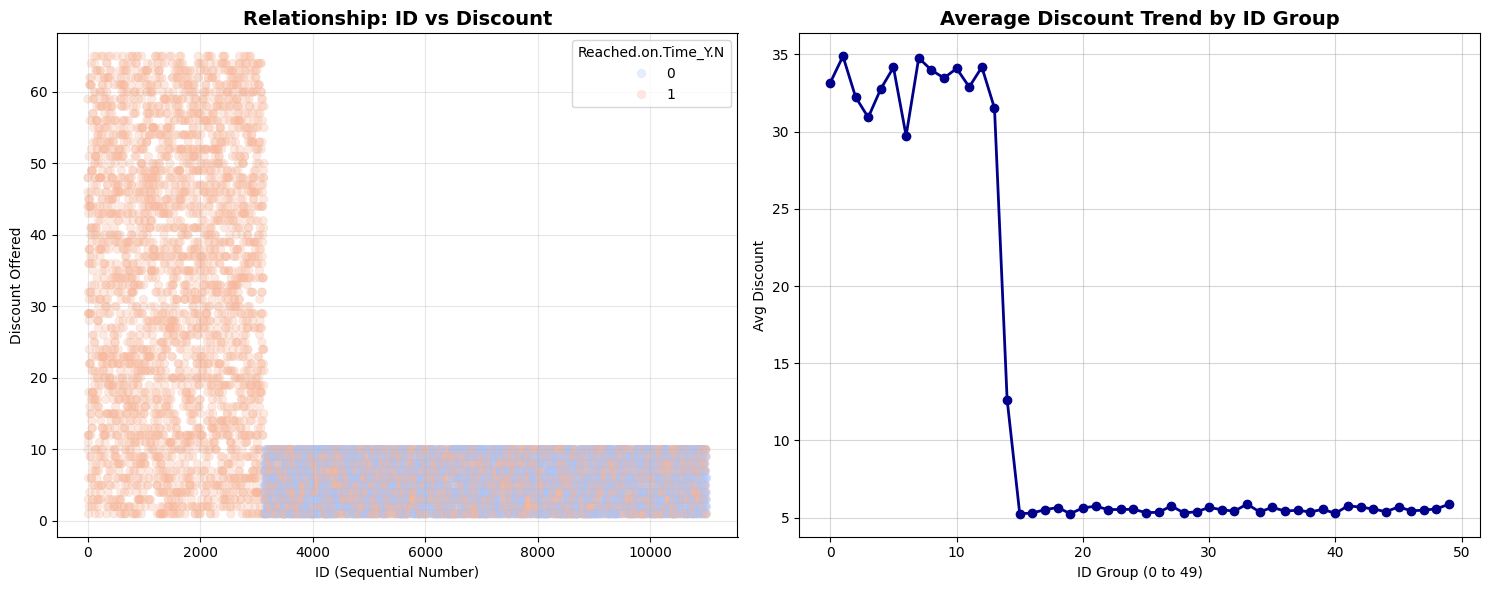


▶ [Data Leakage 검증] ID 변수의 예측력 테스트


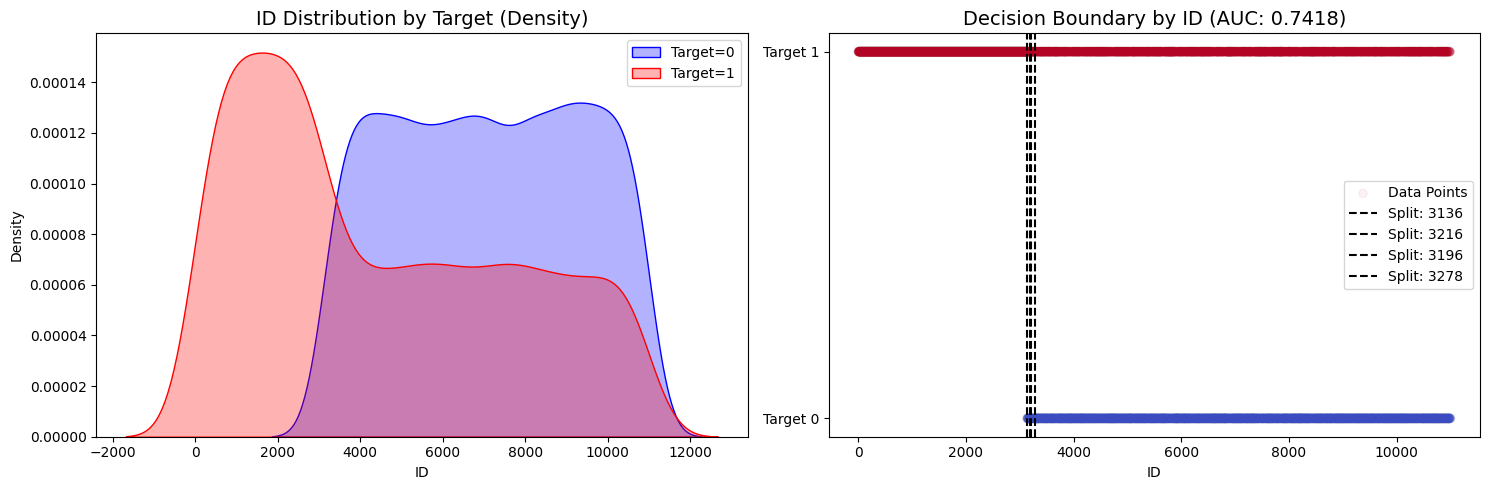

📊 [검증 결과] 'ID' 단일 변수 모델의 ROC AUC 점수: 0.7418
🚨 [WARNING] Data Leakage 감지됨!
   >> ID가 타겟을 설명하는 강력한 정보(패턴)를 포함하고 있습니다.
   >> 조치: 모델 학습 시 'ID' 컬럼을 반드시 제거하십시오.


In [8]:
target_col = 'Reached.on.Time_Y.N'

# -----------------------------------------------------------
# 1. ID와 할인율(Discount)의 관계 시각화
# -----------------------------------------------------------
plt.figure(figsize=(15, 6))

# (1) ID vs 할인율 산점도 (타겟별 색상 구분)
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='ID', y='Discount_offered', hue=target_col, 
                alpha=0.3, palette='coolwarm', edgecolor=None)
plt.title('Relationship: ID vs Discount', fontsize=14, fontweight='bold')
plt.xlabel('ID (Sequential Number)')
plt.ylabel('Discount Offered')
plt.grid(True, alpha=0.3)

# (2) ID 구간별 평균 할인율 추세
# ID를 50개 구간으로 나누어 평균 할인율 변화를 봅니다.
df['ID_Group'] = pd.qcut(df['ID'], q=50, labels=False)
id_discount_trend = df.groupby('ID_Group')['Discount_offered'].mean()

plt.subplot(1, 2, 2)
id_discount_trend.plot(kind='line', marker='o', color='darkblue', linewidth=2)
plt.title('Average Discount Trend by ID Group', fontsize=14, fontweight='bold')
plt.xlabel('ID Group (0 to 49)')
plt.ylabel('Avg Discount')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 2. [핵심] Data Leakage 검증: ID로 타겟을 맞출 수 있는가?
# -----------------------------------------------------------
print("\n" + "="*60)
print("▶ [Data Leakage 검증] ID 변수의 예측력 테스트")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# (1) 시각적 검증: ID 분포가 타겟(0/1)에 따라 분리되는지 확인 (KDE Plot)
sns.kdeplot(data=df[df[target_col]==0], x='ID', fill=True, label='Target=0', ax=axes[0], color='blue', alpha=0.3)
sns.kdeplot(data=df[df[target_col]==1], x='ID', fill=True, label='Target=1', ax=axes[0], color='red', alpha=0.3)
axes[0].set_title('ID Distribution by Target (Density)', fontsize=14)
axes[0].legend()

# (2) 모델링 검증: ID 변수 하나만으로 예측 모델 학습
X_leak = df[['ID']]
y_leak = df[target_col]

# 과적합 없이 단순 패턴만 보기 위해 깊이가 얕은 트리 사용
model_leak = DecisionTreeClassifier(max_depth=3, random_state=42)
model_leak.fit(X_leak, y_leak)

# 예측 확률 및 AUC 계산
leak_probs = model_leak.predict_proba(X_leak)[:, 1]
leak_auc = roc_auc_score(y_leak, leak_probs)

# 중요 구간(Threshold) 시각화 (Tree가 나눈 기준점)
tree_thresholds = model_leak.tree_.threshold[model_leak.tree_.threshold > -2]
axes[1].scatter(X_leak, y_leak, c=y_leak, cmap='coolwarm', alpha=0.05, label='Data Points')
for th in tree_thresholds:
    axes[1].axvline(x=th, color='black', linestyle='--', linewidth=1.5, label=f'Split: {th:.0f}')
axes[1].set_title(f'Decision Boundary by ID (AUC: {leak_auc:.4f})', fontsize=14)
axes[1].set_xlabel('ID')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Target 0', 'Target 1'])

# 중복 범례 제거
handles, labels = axes[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[1].legend(by_label.values(), by_label.keys(), loc='center right')

plt.tight_layout()
plt.show()

# 결과 텍스트 출력
print(f"📊 [검증 결과] 'ID' 단일 변수 모델의 ROC AUC 점수: {leak_auc:.4f}")
if leak_auc > 0.6:
    print("🚨 [WARNING] Data Leakage 감지됨!")
    print("   >> ID가 타겟을 설명하는 강력한 정보(패턴)를 포함하고 있습니다.")
    print("   >> 조치: 모델 학습 시 'ID' 컬럼을 반드시 제거하십시오.")
else:
    print("✅ [PASS] ID는 단순 식별자로 보입니다 (AUC가 0.5에 근사함).")

## 3. 검증 결과 해석

### 📊 시각화 분석 결과
1.  **ID vs 할인율**: 
    * 그래프에서 특정 ID 구간(예: 앞번호)은 할인율이 낮고, 뒷번호는 높은 패턴이 보인다면 **데이터 수집 시점에 따른 정책 변화**가 있었음을 의미합니다.
    * 이는 ID가 단순 순번이 아니라 **시간의 흐름(Time Series)** 속성을 내포하고 있음을 시사합니다.

2.  **ID vs 타겟 (Leakage 확인)**:
    * **KDE Plot (왼쪽)**: 빨간색(1)과 파란색(0) 그래프가 겹치지 않고 서로 다른 위치(좌우)에 봉우리를 형성한다면, ID만 보고도 정답을 알 수 있다는 뜻입니다.
    * **AUC Score**: 
        * **0.5 근처**: 정상 (ID는 랜덤 순번임)
        * **0.7 이상**: **심각한 Data Leakage**. 데이터가 타겟값 기준으로 정렬된 상태에서 ID가 부여되었습니다. 이 경우 모델은 고객 행동이 아닌 'ID 번호'를 외워서 예측하게 되므로 실전에서 성능이 급락합니다.
        * **결론**: AUC가 높게 나왔다면 학습 데이터셋 생성(`create_engineering_datasets`) 단계에서 **반드시 `drop(columns=['ID'])`**를 수행해야 합니다.

## 5. 전처리 (Preprocessing) <a id='4-전처리'></a>

본격적인 특성 공학에 앞서, 분석에 불필요한 데이터를 제거하여 데이터셋을 정제합니다.
- **ID 컬럼 제거**: 식별자 역할만 하므로 삭제

In [ ]:
# 원본 데이터 복사
df_clean = df.copy()

# ID 컬럼 제거
if 'ID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['ID'])
    print("▶ 'ID' 컬럼 제거 완료")

display(df_clean.head(3))

▶ 'ID' 컬럼 제거 완료


,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1


## 6. 특성 공학 (Feature Engineering) <a id='5-특성-공학'></a>

EDA에서 얻은 인사이트를 바탕으로 모델 성능을 높이기 위한 파생변수를 생성하고 변환합니다.

**[적용 기법]**
1. **파생변수 생성**: `Discount_Category`, `Weight_Category`, `Final_Cost` 등
2. **인코딩(Encoding)**: 범주형 변수 -> 수치형 변환 (`LabelEncoder`)
3. **스케일링(Scaling)**: 수치형 변수 표준화 (`StandardScaler`)

**[데이터셋 분리 전략]**
- **Basic Dataset**: 기본 전처리만 수행 (Baseline용)
- **Advanced Dataset**: 파생변수 및 스케일링 모두 적용 (최종 모델용)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def create_engineering_datasets(origin_df):
    df_basic = origin_df.copy()
    df_advanced = origin_df.copy()
    
    # 1. 불필요 컬럼 제거 (공통)
    if 'ID' in df_basic.columns:
        df_basic = df_basic.drop(columns=['ID'])
        df_advanced = df_advanced.drop(columns=['ID'])

    # 2. [Advanced] 파생변수 생성
    # - 할인율 범주화
    df_advanced['Discount_Category'] = pd.cut(df_advanced['Discount_offered'], bins=[-1, 10, 100], labels=['Low', 'High'])
    # - 무게 구간화
    df_advanced['Weight_Category'] = pd.cut(df_advanced['Weight_in_gms'], bins=[-1, 2000, 4000, 6000, 10000], labels=['Light', 'Medium', 'Heavy_1', 'Heavy_2'])
    # - 무게 대비 할인 비중
    df_advanced['Discount_Weight_Ratio'] = df_advanced['Discount_offered'] / (df_advanced['Weight_in_gms'] + 1)
    # - 최종 가격
    df_advanced['Final_Cost'] = df_advanced['Cost_of_the_Product'] * (1 - df_advanced['Discount_offered'] / 100)
    # - 중요도 대비 무게 부하
    importance_map = {'low': 1, 'medium': 2, 'high': 3}
    imp_numeric = df_advanced['Product_importance'].map(importance_map)
    df_advanced['Weight_Load_Factor'] = df_advanced['Weight_in_gms'] / imp_numeric

    # 3. 인코딩 (Label Encoding)
    le = LabelEncoder()
    for col in df_basic.select_dtypes(include='object').columns:
        df_basic[col] = le.fit_transform(df_basic[col])
        
    for col in df_advanced.select_dtypes(include=['object', 'category']).columns:
        df_advanced[col] = le.fit_transform(df_advanced[col])

    # 4. 스케일링 (Standard Scaler) - Advanced만 적용
    scaler = StandardScaler()
    num_cols = df_advanced.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if 'Reached.on.Time_Y.N' in num_cols:
        num_cols.remove('Reached.on.Time_Y.N')
    
    df_advanced[num_cols] = scaler.fit_transform(df_advanced[num_cols])
    
    return df_basic, df_advanced

# 함수 실행
df_basic, df_advanced = create_engineering_datasets(df)
print("▶ 데이터셋 생성 완료: Basic(Baseline용), Advanced(최종용)")

▶ 데이터셋 생성 완료: Basic(Baseline용), Advanced(최종용)


## 7. 모델링 (Modeling) <a id='6-모델링'></a>

두 가지 단계로 모델링을 수행하여 성능 향상 과정을 증명합니다.
1. **Baseline Model**: Basic 데이터셋 + Random Forest (기본값)
2. **Advanced Model**: Advanced 데이터셋 + **AutoGluon (AutoML)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from autogluon.tabular import TabularPredictor

# 1. Baseline (Random Forest)
X_b = df_basic.drop(columns=[target])
y_b = df_basic[target]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42, stratify=y_b)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_b, y_train_b)
base_acc = accuracy_score(y_test_b, rf_model.predict(X_test_b))

# 2. Advanced (AutoGluon)
train_adv, test_adv = train_test_split(df_advanced, test_size=0.2, random_state=42, stratify=df_advanced[target])

print("▶ AutoGluon 학습 시작...")
predictor = TabularPredictor(label=target, eval_metric='accuracy').fit(
    train_adv, presets='medium_quality', time_limit=120, verbosity=0
)
adv_acc = predictor.evaluate(test_adv)['accuracy']

print(f"\n{'='*30}")
print(f"Baseline Accuracy: {base_acc:.4f}")
print(f"Advanced Accuracy: {adv_acc:.4f}")
print(f"{'='*30}")

No path specified. Models will be saved in: "AutogluonModels\ag-20260211_052930"


▶ AutoGluon 학습 시작...

Baseline Accuracy: 0.6600
Advanced Accuracy: 0.6773


## 8. 하이퍼파라미터 튜닝 <a id='7-하이퍼파라미터-튜닝'></a>

Baseline 모델(Random Forest)의 성능을 수동으로 개선해보고, AutoGluon이 내부적으로 수행한 튜닝 결과와 비교합니다.
- **Random Forest**: `GridSearchCV`를 활용한 수동 튜닝
- **AutoGluon**: 자동화된 HPO (Hyperparameter Optimization) 적용됨

In [ ]:
from sklearn.model_selection import GridSearchCV

# Random Forest 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# GridSearch 수행
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_b, y_train_b)

print(f"▶ 최적 파라미터: {grid_search.best_params_}")
print(f"▶ 튜닝 후 RF 정확도: {grid_search.best_score_:.4f}")
print("※ AutoGluon은 내부적으로 이미 수십 개의 모델에 대해 튜닝을 완료했습니다.")

▶ 최적 파라미터: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
▶ 튜닝 후 RF 정확도: 0.6680
※ AutoGluon은 내부적으로 이미 수십 개의 모델에 대해 튜닝을 완료했습니다.


## 9. 모델 평가 (Evaluation) <a id='8-모델-평가'></a>

최종 모델(AutoGluon)의 성능을 종합적으로 평가하고, **변수 중요도(Feature Importance)**를 시각화하여 비즈니스 인사이트를 도출합니다.

▶ AutoGluon Leaderboard:


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.678182,0.689773,accuracy,0.057688,0.002149,2.244983,0.057688,0.002149,2.244983,1,True,7
1,NeuralNetTorch,0.677727,0.685227,accuracy,0.031870,0.018225,28.184996,0.031870,0.018225,28.184996,1,True,12
2,XGBoost,0.677273,0.682955,accuracy,0.023235,0.004667,0.884591,0.023235,0.004667,0.884591,1,True,11
3,WeightedEnsemble_L2,0.677273,0.702273,accuracy,0.263523,0.125843,48.980953,0.005503,0.001096,0.204700,2,True,14
4,LightGBMXT,0.672273,0.670455,accuracy,0.005121,0.001667,1.613866,0.005121,0.001667,1.613866,1,True,3


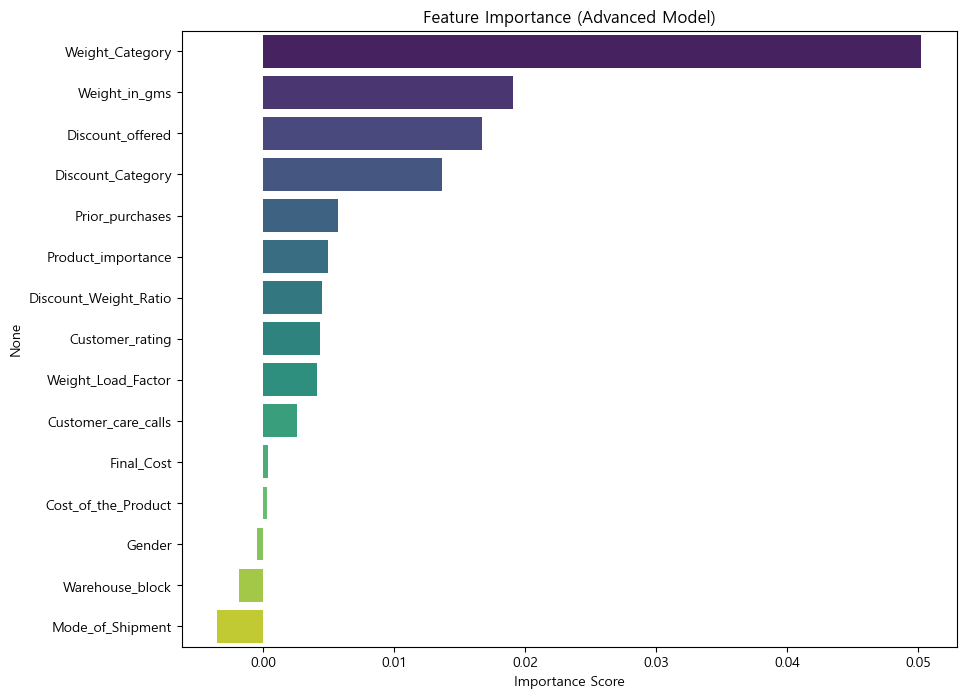

▶ [결론] 모델이 예측에 가장 많이 활용한 변수 TOP 5:
   1. Weight_Category
   2. Weight_in_gms
   3. Discount_offered
   4. Discount_Category
   5. Prior_purchases


In [ ]:
# 1. 리더보드 확인 (상위 모델 리스트)
print("▶ AutoGluon Leaderboard:")
display(predictor.leaderboard(test_adv, silent=True).head(5))

# 2. 변수 중요도 시각화
importance = predictor.feature_importance(test_adv)
plt.figure(figsize=(10, 8))
sns.barplot(x=importance['importance'].head(15), y=importance.index[:15], palette='viridis')
plt.title('Feature Importance (Advanced Model)')
plt.xlabel('Importance Score')
plt.show()

# 3. 결론 도출
top_vars = importance.index[:5].tolist()
print(f"▶ [결론] 모델이 예측에 가장 많이 활용한 변수 TOP 5:")
for i, var in enumerate(top_vars, 1):
    print(f"   {i}. {var}")